# Libraries

In [1]:
import os
import gc
import random
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.manifold import TSNE

import networkx as nx

from IPython.display import display, HTML
from transformers import get_cosine_schedule_with_warmup
tqdm.pandas()

2023-07-06 19:37:52.796463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED = 42


def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        # torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        
seed_all(SEED)

# Load Data

In [3]:
pd_graph = pd.read_csv("data_tr.csv")
pd_graph

,u,v,t,h
0,8538,53245,82,9
1,32991,41149,39,4
2,30104,35030,25,4
3,26292,48613,37,1
4,31603,32991,59,9
...,...,...,...,...
48604,12751,71902,98,4
48605,6430,76576,89,6
48606,1021,6872,83,5
48607,28392,55610,75,8


In [4]:
nodes = sorted(list(set(pd_graph.v.append(pd_graph.u))))
num_nodes = len(nodes)
num_nodes

/var/folders/l3/l0vfq_n54s9d8739l34r9qv00000gn/T/ipykernel_2017/3689112635.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes = sorted(list(set(pd_graph.v.append(pd_graph.u))))


13489

# ID Mapping

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(set(pd_graph.v.append(pd_graph.u))))

pd_graph.u = le.transform(pd_graph.u)
pd_graph.v = le.transform(pd_graph.v)
pd_graph

/var/folders/l3/l0vfq_n54s9d8739l34r9qv00000gn/T/ipykernel_2017/2056397769.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  le.fit(list(set(pd_graph.v.append(pd_graph.u))))


,u,v,t,h
0,1370,8415,82,9
1,5206,6477,39,4
2,4760,5521,25,4
3,4163,7660,37,1
4,5003,5206,59,9
...,...,...,...,...
48604,2028,11429,98,4
48605,1011,12176,89,6
48606,150,1069,83,5
48607,4496,8792,75,8


In [6]:
vocab_size = pd_graph.u.append(pd_graph.v).unique().shape[0]
vocab_size

/var/folders/l3/l0vfq_n54s9d8739l34r9qv00000gn/T/ipykernel_2017/1245813000.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vocab_size = pd_graph.u.append(pd_graph.v).unique().shape[0]


13489

In [7]:
np_graph = pd_graph[["u", "v", "h"]].to_numpy()
np_graph

array([[1370, 8415,    9],
       [5206, 6477,    4],
       [4760, 5521,    4],
       ...,
       [ 150, 1069,    5],
       [4496, 8792,    8],
       [1011, 5098,    3]])

# Dataset

In [8]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import coalesce, to_undirected

/Users/user/PycharmProjects/vk_mini_ml/venv/lib/python3.8/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/user/PycharmProjects/vk_mini_ml/venv/lib/python3.8/site-packages/libpyg.so, 0x0006): Library not loaded: /usr/local/opt/python@3.10/Frameworks/Python.framework/Versions/3.10/Python
  Referenced from: <A3167622-FB1D-3AFD-A72D-977AF8E27A03> /Users/user/PycharmProjects/vk_mini_ml/venv/lib/python3.8/site-packages/libpyg.so
  Reason: tried: '/usr/local/opt/python@3.10/Frameworks/Python.framework/Versions/3.10/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/python@3.10/Frameworks/Python.framework/Versions/3.10/Python' (no such file), '/usr/local/opt/python@3.10/Frameworks/Python.framework/Versions/3.10/Python' (no such file), '/System/Library/Frameworks/Python.framework/Versions/3.10/Python' (no such file, not in dyld cache)
  warnings.warn(f"An issue occurred 

In [9]:
edge_index = torch.from_numpy(np_graph[:, 0:2]).transpose(0, 1).long()
edge_attr = torch.from_numpy(np_graph[:, 2:]).float()

edge_index.shape, edge_attr.shape

(torch.Size([2, 48609]), torch.Size([48609, 1]))

In [10]:
unique_edge_index, unique_edge_attr = coalesce(edge_index, edge_attr)
unique_edge_index.shape, unique_edge_attr.shape

(torch.Size([2, 48609]), torch.Size([48609, 1]))

In [11]:
undirected_edge_index, undirected_edge_attr = to_undirected(unique_edge_index, unique_edge_attr)
undirected_edge_index.shape, undirected_edge_attr.shape

(torch.Size([2, 97218]), torch.Size([97218, 1]))

In [12]:
graph = Data(
    x=torch.tensor([i for i in range(vocab_size)]),
    edge_index=undirected_edge_index,
    edge_attr=undirected_edge_attr,
)

# Model

In [13]:
from torch_geometric.nn import GAE
from torch import nn
import torch_geometric.nn as tgnn


class Encoder(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, num_layers: int, dropout: float = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gnn = tgnn.GAT(
            in_channels=hidden_size,
            hidden_channels=hidden_size,
            out_channels=hidden_size,
            num_layers=num_layers,
            v2=True
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.embedding(x)
        x = self.gnn(x, edge_index)
        return x

# Loss

In [14]:
class GAERegressionLoss(nn.Module):
    def __init__(self, regression_loss=nn.L1Loss()):
        super().__init__()
        self.regression_loss = regression_loss

    def forward(self, logits, target, pos_index):
        u_embedding = logits[pos_index[0]]
        v_embedding = logits[pos_index[1]]

        preds = (u_embedding * v_embedding).sum(dim=1)
        
        return self.regression_loss(preds, target)

# Training

In [15]:
def train_epoch(model, graph, loss_function, optimizer, scheduler, device):
    model.to(device)
    model.train()

    graph = graph.to(device)
    target = graph.edge_attr
    pos_index = graph.edge_index
    
    optimizer.zero_grad()        
    logits = model(graph)
                        
    loss = loss_function(logits, target.flatten(), pos_index)
    total_train_loss = loss.item()
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    
    return total_train_loss
    
    
def eval_epoch(model, graph, loss_function, device):
    model.to(device)
    model.eval()

    graph = graph.to(device)
    target = graph.edge_attr
    pos_index = graph.edge_index


    with torch.no_grad():
        logits = model(graph)
    
    loss = loss_function(logits, target.flatten(), pos_index)
    total_train_loss = loss.item()
    
    return total_train_loss

In [16]:
def train(model, 
          train_graph, 
          eval_graph,
          loss_function, 
          strat_array = None,
          device = torch.device("cuda"),
          random_state: int = 69, 
          epochs: int = 5, 
          get_scheduler = get_cosine_schedule_with_warmup,
         ):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    total_steps = epochs 
    scheduler = get_scheduler(optimizer, 
                              num_warmup_steps = 0, # Default value in run_glue.py
                              num_training_steps = total_steps)

    for epoch_i in range(0, epochs):
        train_metrics = train_epoch(model, train_graph, loss_function, optimizer, scheduler, device)
        eval_metrics = eval_epoch(model, eval_graph, loss_function, device)
        
        print(f"EPOCH: {epoch_i}")
        print(train_metrics)
        print(eval_metrics)

In [17]:
loss_function = GAERegressionLoss(
    regression_loss=nn.MSELoss()
)

model = GAE(
    encoder=Encoder(vocab_size=vocab_size, hidden_size=64, num_layers=1, dropout=0.1)
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 5e-3
)

In [18]:
train(model=model, 
      train_graph=graph, 
      eval_graph=graph,
      loss_function=loss_function, 
      device=torch.device("cpu"),
      random_state=SEED, 
      epochs=5,
      get_scheduler=get_cosine_schedule_with_warmup)

EPOCH: 0
76.05381774902344
57.993438720703125
EPOCH: 1
57.993438720703125
47.779911041259766
EPOCH: 2
47.779911041259766
42.409629821777344
EPOCH: 3
42.409629821777344
39.99766159057617
EPOCH: 4
39.99766159057617
39.36155700683594


# Model Analisys

In [19]:
with torch.no_grad():
    embeddings = model.cpu()(graph)

embeddings.shape

torch.Size([13489, 64])

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, verbose=1)
embeddings_2d = tsne.fit_transform(embeddings.numpy())
embeddings_2d.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13489 samples in 0.001s...
[t-SNE] Computed neighbors for 13489 samples in 0.548s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13489
[t-SNE] Computed conditional probabilities for sample 2000 / 13489
[t-SNE] Computed conditional probabilities for sample 3000 / 13489
[t-SNE] Computed conditional probabilities for sample 4000 / 13489
[t-SNE] Computed conditional probabilities for sample 5000 / 13489
[t-SNE] Computed conditional probabilities for sample 6000 / 13489
[t-SNE] Computed conditional probabilities for sample 7000 / 13489
[t-SNE] Computed conditional probabilities for sample 8000 / 13489
[t-SNE] Computed conditional probabilities for sample 9000 / 13489
[t-SNE] Computed conditional probabilities for sample 10000 / 13489
[t-SNE] Computed conditional probabilities for sample 11000 / 13489
[t-SNE] Computed conditional probabilities for sample 12000 / 13489
[t-SNE] Computed conditional probabilities for sam

(13489, 2)

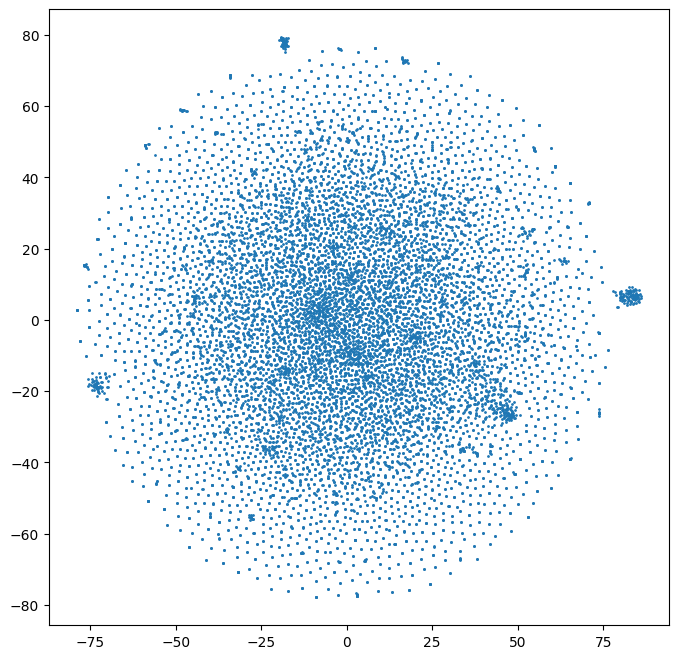

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1)

# Prediction

In [22]:
scores = torch.mm(embeddings, embeddings.T).relu()
scores.shape

torch.Size([13489, 13489])

In [23]:
existing_pairs = set(zip(pd_graph.u.to_list(), pd_graph.v.to_list()))

In [24]:
for pair in existing_pairs:
    u, v = pair
    scores[u, v] = 0
    scores[v, u] = 0

In [25]:
predictions = list(scores.topk(k=10, dim=1).indices.numpy())
for i in range(len(predictions)):
    predictions[i] = le.inverse_transform(predictions[i])

In [26]:
user_ids = le.inverse_transform([i for i in range(num_nodes)])
list_ids = predictions
lines = [f"{user_ids[i]}: {','.join(list(map(str, list_ids[i])))}" for i in tqdm(range(num_nodes))]
lines

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 13489/13489 [00:00<00:00, 97637.23it/s]


['2: 2,66621,83615,5350,58792,48809,5402,25914,37207,67333',
 '19: 19,5051,46120,34458,26777,49320,75996,54857,374,54923',
 '22: 22,66111,24506,81298,24593,11967,65083,15603,7618,73289',
 '25: 70665,41205,55827,21436,57010,71524,75936,64272,61397,66871',
 '26: 68171,23838,78493,58436,27772,31827,21965,10611,42207,34338',
 '29: 29,76406,48347,61739,81495,68031,59649,2340,30382,21617',
 '31: 31,79910,22387,26373,76859,7445,47161,72456,83503,480',
 '33: 33,78237,11380,3672,66620,59649,42465,34713,5256,35994',
 '38: 38,42953,60523,7603,69434,46452,20463,647,5571,50046',
 '40: 74665,5705,14170,79698,55626,46863,26679,6251,20881,15579',
 '46: 51950,41556,65479,26679,33842,22657,51896,70520,55110,83497',
 '50: 50,16767,2159,379,56922,2059,62811,68523,41783,48346',
 '51: 51,59747,44624,36039,57365,27385,38146,41834,71646,27856',
 '55: 55,46137,4452,50872,11452,66653,41187,52595,30187,18805',
 '67: 67,11070,45648,5904,82074,62622,80341,48365,75600,35719',
 '72: 62568,46944,83357,34458,73313,110

In [27]:
with open("GAE.txt", "w") as fout:
    print("\n".join(lines), file=fout)